# Precipitação EPAGRI
Foram somadas as precipitações de 1h às 0h do dia seguinte.
## Período de 20/09/2023 a 31/12/2023:

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, Normalize 
import numpy as np
import calplot

In [2]:
# Carregar dados
pasta = 'C:\\ENS\\LAUTEC'
dados = pd.read_excel(pasta+'\\Inputs\\prec horario.xlsx',
                      header=8).set_index('Data')
dados.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2472 entries, 2023-09-20 01:00:00 to 2024-01-01 00:00:00
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Dado    2472 non-null   float64
dtypes: float64(1)
memory usage: 38.6 KB


In [3]:
# Verificar se há dados faltantes
'''
datas = pd.date_range(start='2023-09-20 01:00:00', end='2024-01-01 00:00:00', freq='h')
horas_index = datas.strftime("%Y-%m-%d %H:%M")
horas_df = dados.index.strftime("%Y-%m-%d %H:%M")
horas_faltantes = horas_index.difference(horas_df)
horas_faltantes
'''

'\ndatas = pd.date_range(start=\'2023-09-20 01:00:00\', end=\'2024-01-01 00:00:00\', freq=\'h\')\nhoras_index = datas.strftime("%Y-%m-%d %H:%M")\nhoras_df = dados.index.strftime("%Y-%m-%d %H:%M")\nhoras_faltantes = horas_index.difference(horas_df)\nhoras_faltantes\n'

In [4]:
dados = dados.reset_index().drop('Data', axis='columns')

In [5]:
# Somar os dados em intervalos de 24h (24 linhas)
soma1 = dados.groupby(dados.index//24).sum()
soma1 = soma1.set_index(
    (pd.date_range('2023-09-20', '2023-12-31', freq='D')).date) 

## Período de 01/01/2024 a 16/11/2024:

In [6]:
# Carregar dados
dados = pd.read_excel(
    pasta+'\\Inputs\\DH2024_Pricila Campos-EST-Fpolis-10-2024_Fabricio.xls',
    header=8)
dados['Data'] = pd.to_datetime(dados['Data'], format='%d/%m/%Y %H:%M') 
dados = dados.set_index('Data')
dados.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7704 entries, 2024-01-01 01:00:00 to 2024-11-17 00:00:00
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Dado    7704 non-null   object
dtypes: object(1)
memory usage: 120.4+ KB


In [7]:
# Verificar se há dados faltantes
'''
datas = pd.date_range(start='2024-01-01 01:00:00', end='2024-11-17 00:00:00', freq='h')
horas_index = datas.strftime("%Y-%m-%d %H:%M")
horas_df = dados.index.strftime("%Y-%m-%d %H:%M")
horas_faltantes = horas_index.difference(horas_df)
horas_faltantes
'''

'\ndatas = pd.date_range(start=\'2024-01-01 01:00:00\', end=\'2024-11-17 00:00:00\', freq=\'h\')\nhoras_index = datas.strftime("%Y-%m-%d %H:%M")\nhoras_df = dados.index.strftime("%Y-%m-%d %H:%M")\nhoras_faltantes = horas_index.difference(horas_df)\nhoras_faltantes\n'

In [8]:
dados = dados.replace('-', 'NaN').astype(float)
dados = dados.reset_index().drop('Data', axis='columns')

In [9]:
# Somar os dados em intervalos de 24h (24 linhas)
soma2 = dados.groupby(dados.index//24).sum()
soma2 = soma2.set_index(
    (pd.date_range('2024-01-01', '2024-11-16', freq='D')).date) 

# Mapas de calor/Heatmaps
https://calplot.readthedocs.io/en/stable/ 

In [10]:
# Unir os resultados encontrados anteriormente 
resultado = pd.concat([soma1, soma2]).reset_index()

# Função para identificar os dias secos
dia_seco = lambda oito_dias: all(prec<=4 for prec in oito_dias)

# Aplicar função
resultado['Dia seco'] = resultado[
    'Dado'].rolling(window=8).apply(dia_seco) 

# Salvar planilha
with pd.ExcelWriter(pasta+'\\Outputs\\prec_epagri_corrigido.xlsx') as writer:
    resultado.to_excel(writer, sheet_name='Resultado')
    soma1.to_excel(writer, sheet_name='2023') 
    soma2.to_excel(writer, sheet_name='2024') 

In [11]:
# Rótulos personalizados/traduzidos
daylabels = ['Seg', 'Ter', 'Qua', 'Qui', 'Sex', 'Sáb', 'Dom']
monthlabels = ['Jan', 'Fev', 'Mar', 'Abr', 'Mai', 'Jun', 
               'Jul', 'Ago', 'Set', 'Out', 'Nov', 'Dez'] 

In [12]:
# Criar categorias de precipitação para plotar 
def categoria(prec): 
    if prec <= 4: 
        return 2
    elif prec>4 and prec<=10: 
        return 3 
    else:
        return 4
        
resultado['Categoria'] = resultado['Dado'].apply(categoria) 

# Nova categoria para identificar os dias secos
for i in range(len(resultado)):
    if resultado.loc[i, 'Dia seco'] == True:
        resultado.loc[i, 'Categoria'] = 1
    else:
        continue
resultado = resultado.set_index(pd.to_datetime(resultado['index'])) 

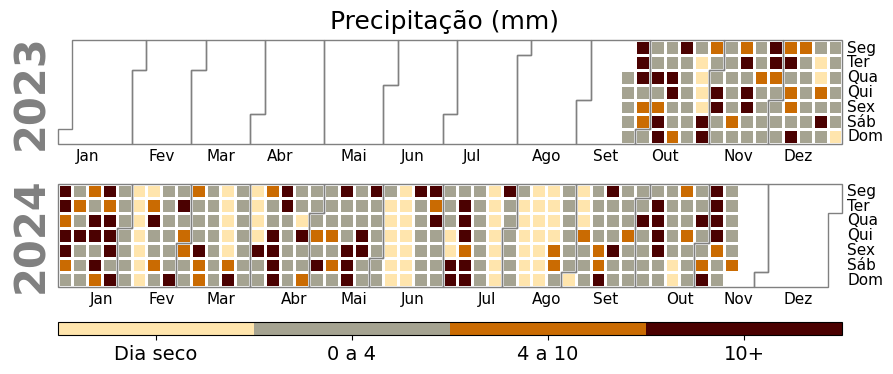

In [13]:
# Heatmap 
cores = ['xkcd:pale peach', 'xkcd:cement', 'xkcd:browny orange', 'xkcd:dried blood']
N = len(cores) 
cmap = LinearSegmentedColormap.from_list('', cores, N)

fig, ax = calplot.calplot(resultado['Categoria'], 
                          how=None,
                          cmap=cmap,
                          colorbar=False,
                          fillcolor='white', 
                          suptitle = 'Precipitação (mm)',
                          suptitle_kws = {'fontsize': '18'},
                          daylabels = daylabels,
                          monthlabels = monthlabels,
                          yearlabel_kws={'fontname':'sans'},
                          figsize=(9,3.8))
ax[0].tick_params(labelsize=11)
ax[1].tick_params(labelsize=11)
plt.subplots_adjust(hspace=0.2) 

# Colorbar personalizada 
norm = Normalize(vmin=0, vmax=1)  
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # Necessário para o colorbar funcionar

bounds = np.linspace(0, 1, 5)  # 4 intervalos
cbar = plt.colorbar(sm, 
                    ax = ax, 
                    boundaries = bounds, 
                    ticks = bounds[:-1]+(bounds[1]-bounds[0]) / 2,
                    location = 'bottom',
                    aspect = 60,
                    pad = 0.1)

cbar.set_ticklabels(['Dia seco', '0 a 4', '4 a 10', '10+'])
cbar.ax.tick_params(labelsize=14)  

plt.savefig(pasta+'\\Outputs\\precipitacao.png', bbox_inches='tight')